In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

### **Getting to know my data & Feature Engineering**

In [16]:
# Loading the data from zipped file
df = pd.read_csv("../../data/textual/British Airways Customer Reviews.zip")
df.sample(n=5,random_state=42)

,Unnamed: 0,rating,country,review,date,verified
1037,1037,5.0,United Kingdom,Paphos to London Gatwick in Club Europe. We ha...,2018-08-09,True
1494,1494,1.0,United Kingdom,On the 13th June 2017 I travelled from Mykonos...,2017-06-29,True
2254,2254,3.0,United Kingdom,Miami to Manchester via London Heathrow with B...,2016-03-31,False
2771,2771,6.0,United Kingdom,Concord lounge was more business class then fi...,2015-07-18,False
3377,3377,3.0,United Kingdom,I have flown twice with BA now in business cla...,2014-09-01,False


In [17]:
df.columns

Index(['Unnamed: 0', 'rating', 'country', 'review', 'date', 'verified'], dtype='object')

In [18]:
# Dropping unnecessary columns
df.drop(columns=['Unnamed: 0'],inplace=True)

In [19]:
print(df.columns)
print(df.shape)

Index(['rating', 'country', 'review', 'date', 'verified'], dtype='object')
(3617, 5)


In [20]:
df.isna().sum()

rating      5
country     2
review      0
date        0
verified    0
dtype: int64

In [21]:
# Dropping null values
df.dropna(axis=1,inplace=True)

In [22]:
df.describe()

,review,date,verified
count,3617,3617,3617
unique,3604,1763,2
top,LHR-HKG-LHR in First. A brief trip to celebrat...,2015-01-19,True
freq,2,26,1862


In [23]:
# Checking for duplicates
print(df.duplicated('review').sum()) 

13


In [24]:
df[df.duplicated('review')]

,review,date,verified
2473,British Airways from Tampa to Gatwick on Boein...,2015-11-20,False
2475,London Heathrow to Miami on one of British Air...,2015-11-20,False
3100,LGW-MLA. For some crazy reason I still fly Bri...,2015-01-19,False
3101,Return trip (LHR to JFK) in Business class. Ex...,2015-01-19,False
3102,MAN-LHR-LAX. Flew Manchester to LAX via Heathr...,2015-01-19,False
3103,Miami to Brussels with a change at Heathrow te...,2015-01-19,False
3104,LGW-CUN Club World seat 4A. To be honest I was...,2015-01-19,False
3105,Recently completed a round-trip LGW-Barcelona....,2015-01-19,False
3106,LHR-HKG-LHR in First. A brief trip to celebrat...,2015-01-19,False
3107,BA179 Jan 6 2015 LHR-JFK. First. T5 is great f...,2015-01-19,False


In [25]:
# Drop duplicates
df.drop_duplicates(subset='review',inplace=True)

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 3604 entries, 0 to 3616
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    3604 non-null   object
 1   date      3604 non-null   object
 2   verified  3604 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 3.9 MB


In [27]:
df.describe()

,review,date,verified
count,3604,3604,3604
unique,3604,1763,2
top,As usual the flight is delayed. BA try to blam...,2015-01-19,True
freq,1,18,1862


In [28]:
# Some feature engineering
df['year'] = df['date'].apply(lambda x: x.split("-")[0])
df['month'] = df['date'].apply(lambda x: x.split("-")[1])

In [29]:
# Column rearrangement
reorder = ['review', 'date','year', 'month','verified']
df = df[reorder]
df.head()

,review,date,year,month,verified
0,As usual the flight is delayed. BA try to blam...,2023-08-04,2023,08,True
1,I had the most fantastic BA Flight today. The ...,2023-08-01,2023,08,True
2,Couldn’t book in online. Arrived at check in t...,2023-07-31,2023,07,True
3,London Heathrow to Mumbai in a Boeing 787-8 in...,2023-07-31,2023,07,True
4,"Keflavík, Iceland to London Heathrow on an A32...",2023-07-31,2023,07,True


In [30]:
# Getting the length of the text
text_length = [len(length.split()) for length in df.loc[:,'review']]
df['review_length'] = text_length
reorder = ['review', 'review_length','date','year', 'month','verified']
df = df[reorder]
df.head()

,review,review_length,date,year,month,verified
0,As usual the flight is delayed. BA try to blam...,32,2023-08-04,2023,08,True
1,I had the most fantastic BA Flight today. The ...,187,2023-08-01,2023,08,True
2,Couldn’t book in online. Arrived at check in t...,68,2023-07-31,2023,07,True
3,London Heathrow to Mumbai in a Boeing 787-8 in...,119,2023-07-31,2023,07,True
4,"Keflavík, Iceland to London Heathrow on an A32...",117,2023-07-31,2023,07,True


In [31]:
# Inspecting some reviews
print(df['review'][0],"\n")
print(df['review'][1])

As usual the flight is delayed. BA try to blame someone for the inability and incapacity of delivering what they sell. Why don't you hire enough personnel to fulfil your staff demand. 

I had the most fantastic BA Flight today. The cabin crew in my seat zone 6D were of the best I have experienced. Although the 777 had the old style rear/front seating - it was comfortable and felt open and spacious. BA have done great things with the menu - it was nice not to have to eat breakfast food on the pre-arrival meal into HKG at 1730PM local time having left London at 2200 the night before. The dinner offering was equally ample and delicious. The inflight entertainment had a great collection of TV and current films and the inflight map was first rate. Previously not a huge BA fan - but after this 12 hour flight I could only recommend it without reserve. I flew the new BA suite in J class on a recent Delhi to London flight and enjoyed that product (although I felt it slightly more cramped ) but 

In [32]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 3604 entries, 0 to 3616
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         3604 non-null   object
 1   review_length  3604 non-null   int64 
 2   date           3604 non-null   object
 3   year           3604 non-null   object
 4   month          3604 non-null   object
 5   verified       3604 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 4.5 MB


In [33]:
df.describe()

,review_length
count,3604.000000
mean,160.175916
std,105.791054
min,15.000000
25%,86.000000
50%,133.000000
75%,202.000000
max,654.000000


In [34]:
# Type conversion
df.review_length = df.review_length.astype('int16')

### **Text Analytics**

In [35]:
# Make a copy of the cleaned and feature engineered data
text_anal = df.copy()
text_anal.columns

Index(['review', 'review_length', 'date', 'year', 'month', 'verified'], dtype='object')

In [36]:
(text_anal.groupby('month')['review_length']
.agg([('Count','count'),('Max','max'),
('Min','min'), ("Mean",'mean'),
('Deviation','std'),('Skew','skew'),
("Median",'median')]).reset_index()).sort_values(by="Deviation", ascending=True)

,month,Count,Max,Min,Mean,Deviation,Skew,Median
6,07,318,639,29,153.522013,96.765601,1.967782,132.5
8,09,299,626,24,159.762542,99.947673,1.400676,140.0
2,03,262,618,25,154.664122,100.597419,1.872711,130.5
7,08,276,654,15,156.500000,102.780242,1.706144,129.5
5,06,356,612,25,160.584270,103.981126,1.386170,129.5
3,04,292,653,29,168.342466,107.227922,1.606879,139.0
0,01,312,592,23,167.894231,107.613240,1.415058,137.5
4,05,327,617,16,156.954128,108.140676,1.552614,130.0
9,10,351,634,22,159.447293,108.705037,1.783291,132.0
1,02,218,598,27,159.247706,109.386657,1.619996,129.0


**Observations**
- There were high number of reviews and flights in the month of June over 12 years.
- The longest review length by a customer is 654 words which was in the month of August.
- The lowest review was in the month of August having a total of 15 words.
- July has the lowest deviation, meaning less variabilty in the review length. 

In [37]:
(text_anal.groupby('year')['review_length']
.agg([('Count','count'),('Max','max'),
('Min','min'), ("Mean",'mean'),
('Deviation','std'),('Skew','skew'),
("Median",'median')]).reset_index()).sort_values(by="Deviation", ascending=True)

,year,Count,Max,Min,Mean,Deviation,Skew,Median
1,2012,12,241,25,132.416667,69.672557,0.230146,120.5
2,2014,465,503,16,142.374194,89.511713,1.328366,120.0
3,2015,728,622,15,151.287088,92.635707,1.479629,127.5
7,2019,356,654,23,134.171348,93.379259,1.965156,111.5
9,2021,87,535,24,141.735632,97.653095,1.875742,117.0
0,2011,3,230,33,126.666667,98.855113,0.435830,117.0
8,2020,104,563,25,145.173077,100.605395,1.905219,128.0
10,2022,213,570,24,153.122066,102.414226,1.343664,122.0
6,2018,324,627,29,160.765432,106.253686,1.707042,132.0
4,2016,570,653,45,176.535088,111.983631,1.584609,150.0


**Observations**
- There were high number of reviews and flights in the year 2015.
- The longest review length by a customer is 654 words which was in the month of August, 2019.
- The lowest review was in the month of August, 2015 having a total of 15 words.
- 2012 has the lowest deviation, meaning less variabilty in the review length, and the skewness is quite low. We could see that the count/no. of reviews/flights is just 12.

In [38]:
def outliers(data,col):
    Q_1 = np.quantile(data[col],0.25)
    Q_3 = np.quantile(data[col],0.75)
    IQR = Q_3 - Q_1 
    lower_bound = Q_1 - (1.5* IQR)
    upper_bound = Q_3 + (1.5* IQR)
    IQR_values = ((data[col] >= Q_1) & (data[col] <= Q_3)).sum()
    outliers_beyond_upper_bound = (data[col] > upper_bound).sum()
    outliers_below_lower_bound = (data[col]  < lower_bound).sum()
    print(f"IQR value for column {col} is: {IQR}")
    print(f"Q_1 value for column {col} is: {Q_1}")
    print(f"Q_3 value for column {col} is: {Q_3}")
    print(f"Lower bound value for column {col} is: {lower_bound}")
    print(f"Upper bound value for column {col} is: {upper_bound}")
    print(f"The number of values within the IQR for {col} is {IQR_values}")
    print(f"The number of outliers beyond the upper bound for {col} is {outliers_beyond_upper_bound}")
    print(f"The number of outliers below the lower bound for {col} is {outliers_below_lower_bound}\n")

In [39]:
outliers(text_anal,"review_length")

IQR value for column review_length is: 116.0
Q_1 value for column review_length is: 86.0
Q_3 value for column review_length is: 202.0
Lower bound value for column review_length is: -88.0
Upper bound value for column review_length is: 376.0
The number of values within the IQR for review_length is 1808
The number of outliers beyond the upper bound for review_length is 171
The number of outliers below the lower bound for review_length is 0



In [40]:
text_anal.head(1)

,review,review_length,date,year,month,verified
0,As usual the flight is delayed. BA try to blam...,32,2023-08-04,2023,08,True


In [41]:
sns.set_theme(style="whitegrid")

In [42]:
# text_anal.month.unique().tolist()
# ['08', '07', '06', '05', '04', '03', '02', '01', '12', '11', '10', '09']

In [43]:
def boxplot_month_analytics(month_date='04'):
    try:    
        value = (text_anal.month == month_date) # boolean
        the_month = text_anal[value] # new dataframe for each month
        
        fig,ax = plt.subplots(figsize=(10,5),constrained_layout=True)
        sns.boxplot(data=the_month,x='review_length')
        ax.set_title(f'The box plot of {month_date}',fontdict={'size':20})
        
        # in terms of males 
        the_month_review_length = the_month[['review_length']]
        for i in the_month_review_length.columns:
            outliers(the_month_review_length, i)
    except IndexError:
        print(f"The wrong index was passed\nPlease look are the information below for correct index\n")
        print(text_anal.month.sort_values().unique())

In [44]:
def boxplot_year_analytics(year_date='2010'):
    try:    
        value = (text_anal.year == year_date) # boolean
        the_year = text_anal[value] # new dataframe
        
        fig,ax = plt.subplots(figsize=(10,5),constrained_layout=True)
        sns.boxplot(data=the_year,x='review_length')
        ax.set_title(f'The box plot of {year_date}',fontdict={'size':20})
        
        # in terms of males 
        the_year_review_length = the_year[['review_length']]
        for i in the_year_review_length.columns:
            outliers(the_year_review_length, i)
    except IndexError:
        print(f"The wrong index was passed\nPlease look are the information below for correct index\n")
        print(text_anal.year.sort_values().unique())

IQR value for column review_length is: 114.0
Q_1 value for column review_length is: 84.0
Q_3 value for column review_length is: 198.0
Lower bound value for column review_length is: -87.0
Upper bound value for column review_length is: 369.0
The number of values within the IQR for review_length is 141
The number of outliers beyond the upper bound for review_length is 17
The number of outliers below the lower bound for review_length is 0



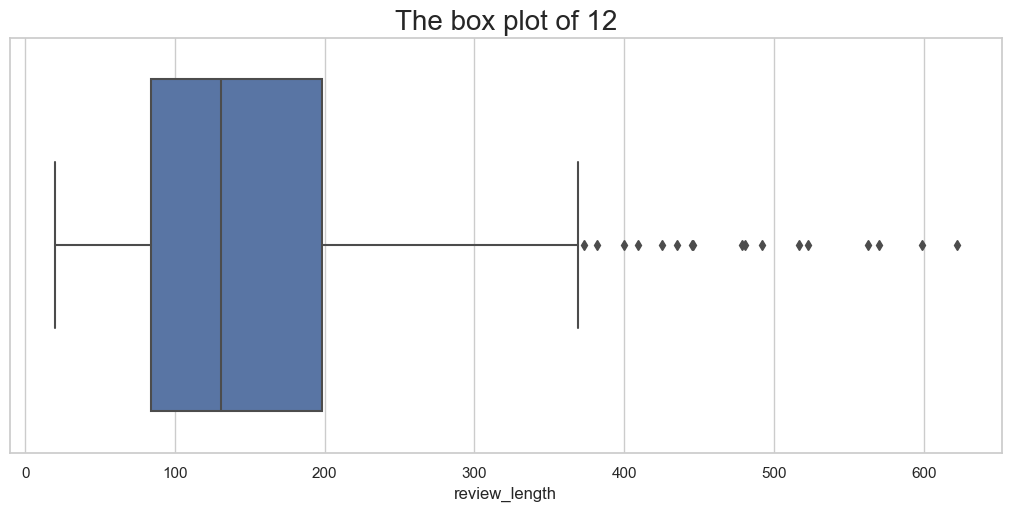

In [45]:
boxplot_month_analytics("12")

IQR value for column review_length is: 104.0
Q_1 value for column review_length is: 78.0
Q_3 value for column review_length is: 182.0
Lower bound value for column review_length is: -78.0
Upper bound value for column review_length is: 338.0
The number of values within the IQR for review_length is 233
The number of outliers beyond the upper bound for review_length is 20
The number of outliers below the lower bound for review_length is 0



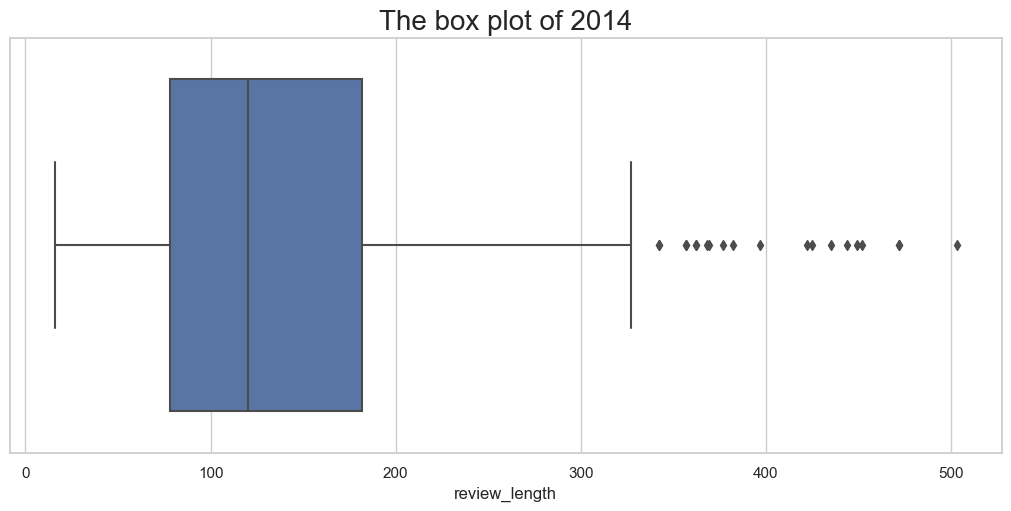

In [46]:
boxplot_year_analytics("2014")

In [47]:
# More dynamic
def year_month(form:str):
    if form == 'month':
        date = list(text_anal.month.sort_values().unique()) 
    else:
        date = list(text_anal.year.sort_values().unique())       

    try:
        # date = list(text_anal.month.sort_values().unique())
        for index,val in enumerate(date):
            value = (text_anal[form] == val) # The boolean 
            the_date_form = text_anal.loc[value] # New dataframe 

            colors_list = ['red','darkgreen','indigo','deepskyblue','darkmagenta','midnightblue',
                            'crimson','chocolate','darkgreen','royalblue','cyan','yellow']
            # Making the box plot
            fig,ax = plt.subplots(1, figsize=(20,5))
            sns.boxplot(data=the_date_form,x='review_length',color=colors_list[index])
            ax.set_title(f"The box plot of review_length for {val} with review_length",fontdict={'size':15})
            plt.subplots_adjust(wspace=0.1)

            # The outliers
            the_date_form_outlier = the_date_form[['review_length']]
            for i in the_date_form_outlier.columns:
                print(f"Information for {val}")
                outliers(the_date_form_outlier, i)
    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_date_form.info(memory_usage='deep')

Information for 2011
IQR value for column review_length is: 98.5
Q_1 value for column review_length is: 75.0
Q_3 value for column review_length is: 173.5
Lower bound value for column review_length is: -72.75
Upper bound value for column review_length is: 321.25
The number of values within the IQR for review_length is 1
The number of outliers beyond the upper bound for review_length is 0
The number of outliers below the lower bound for review_length is 0

Information for 2012
IQR value for column review_length is: 100.25
Q_1 value for column review_length is: 77.75
Q_3 value for column review_length is: 178.0
Lower bound value for column review_length is: -72.625
Upper bound value for column review_length is: 328.375
The number of values within the IQR for review_length is 6
The number of outliers beyond the upper bound for review_length is 0
The number of outliers below the lower bound for review_length is 0

Information for 2014
IQR value for column review_length is: 104.0
Q_1 value f

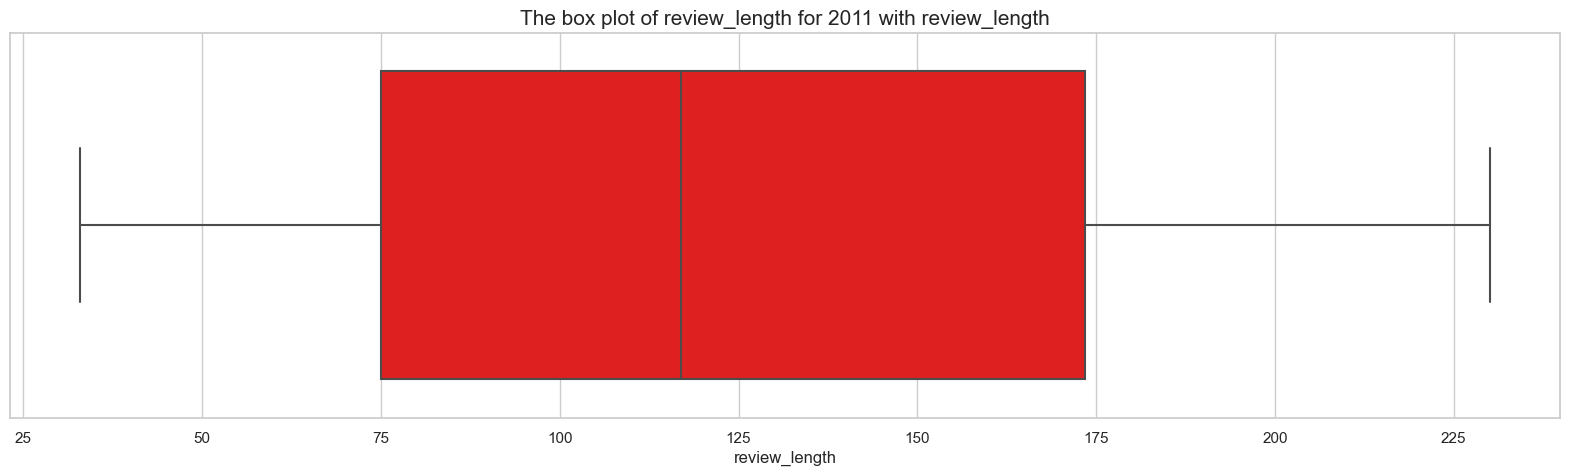

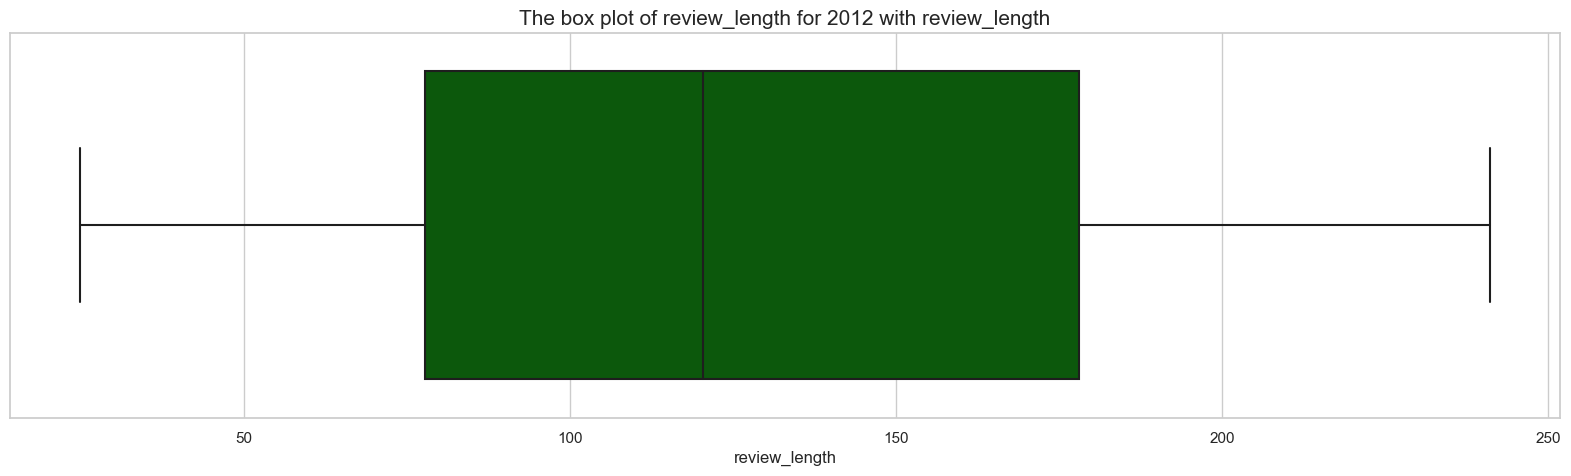

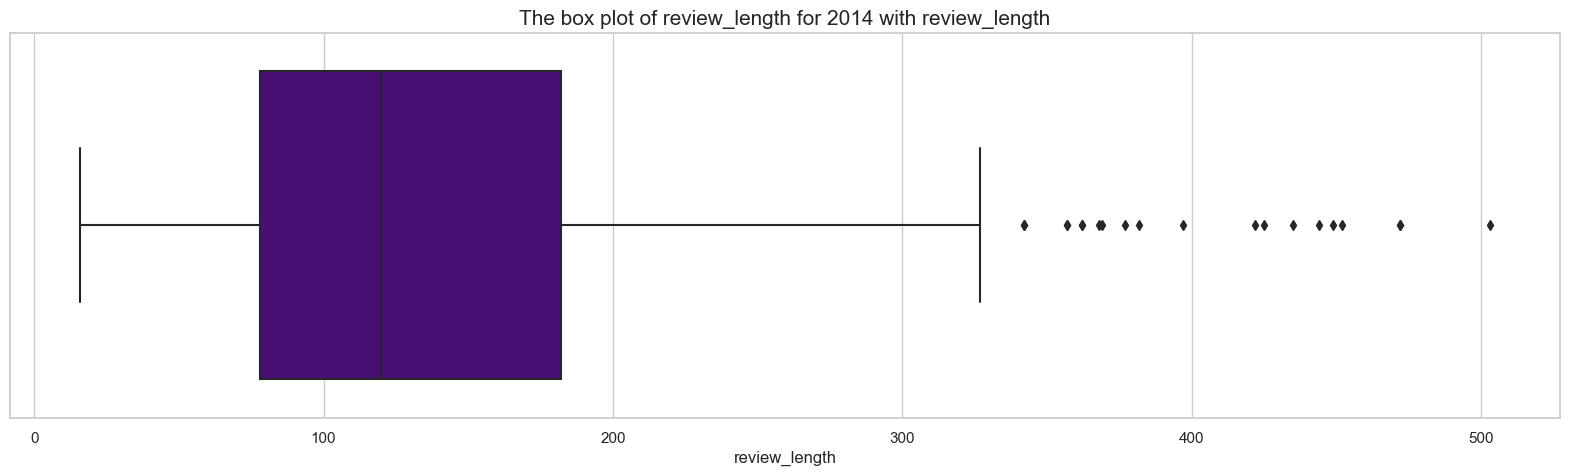

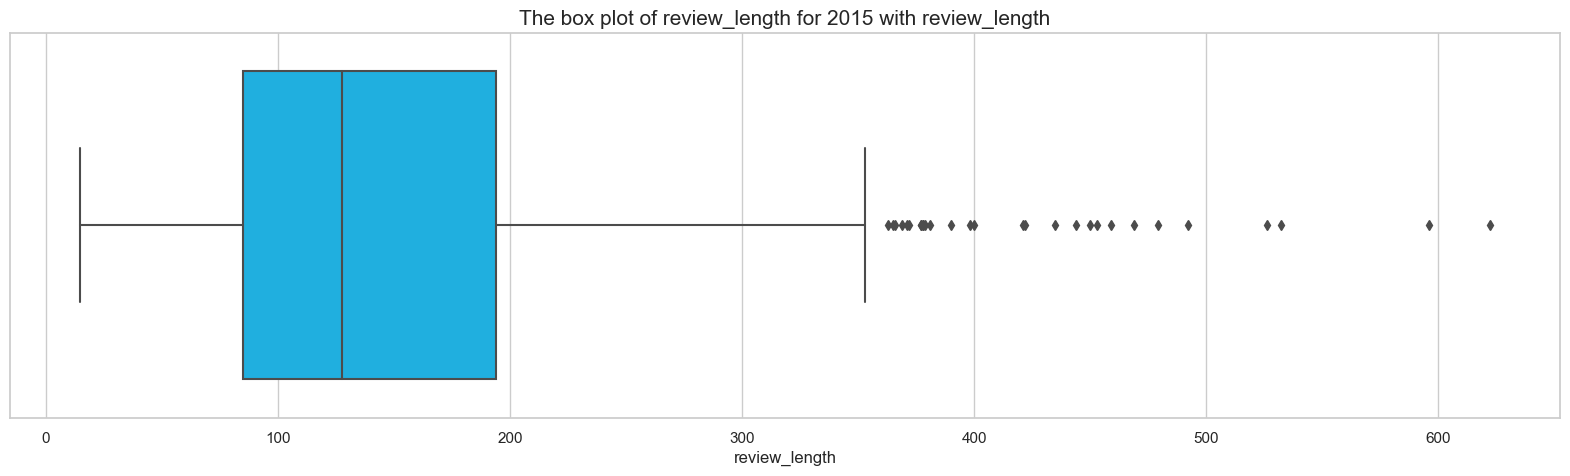

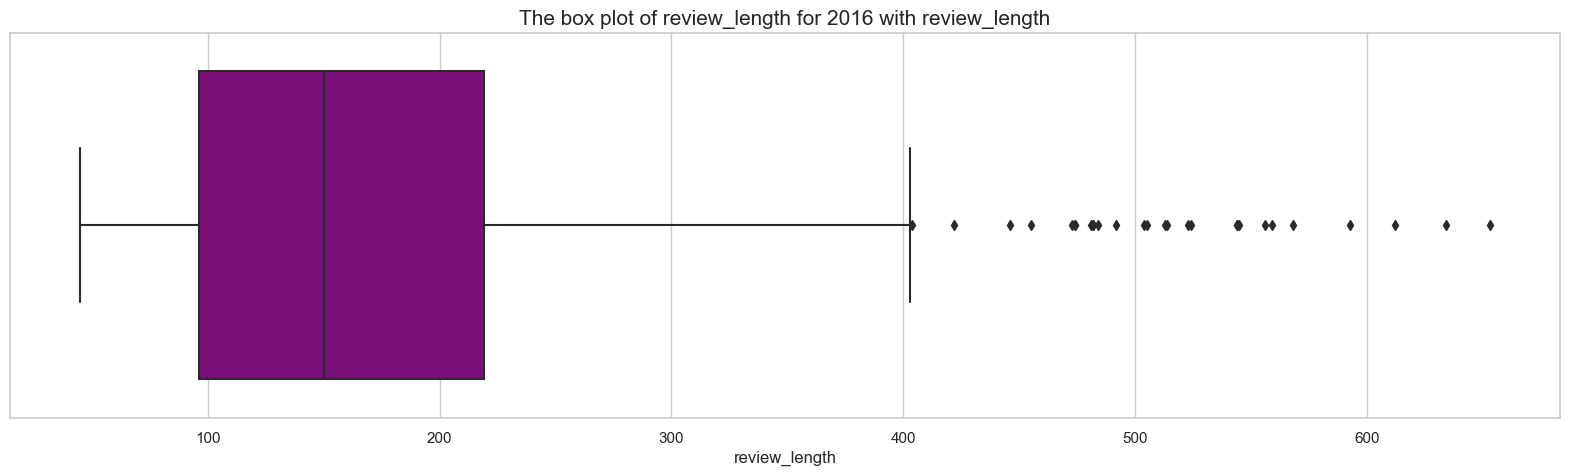

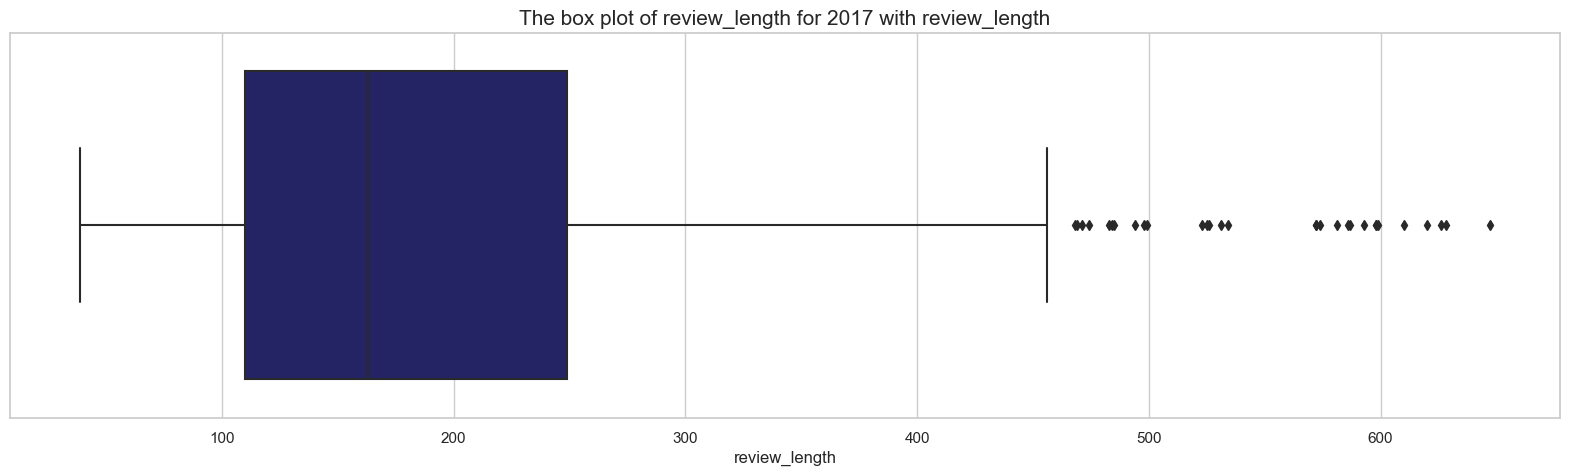

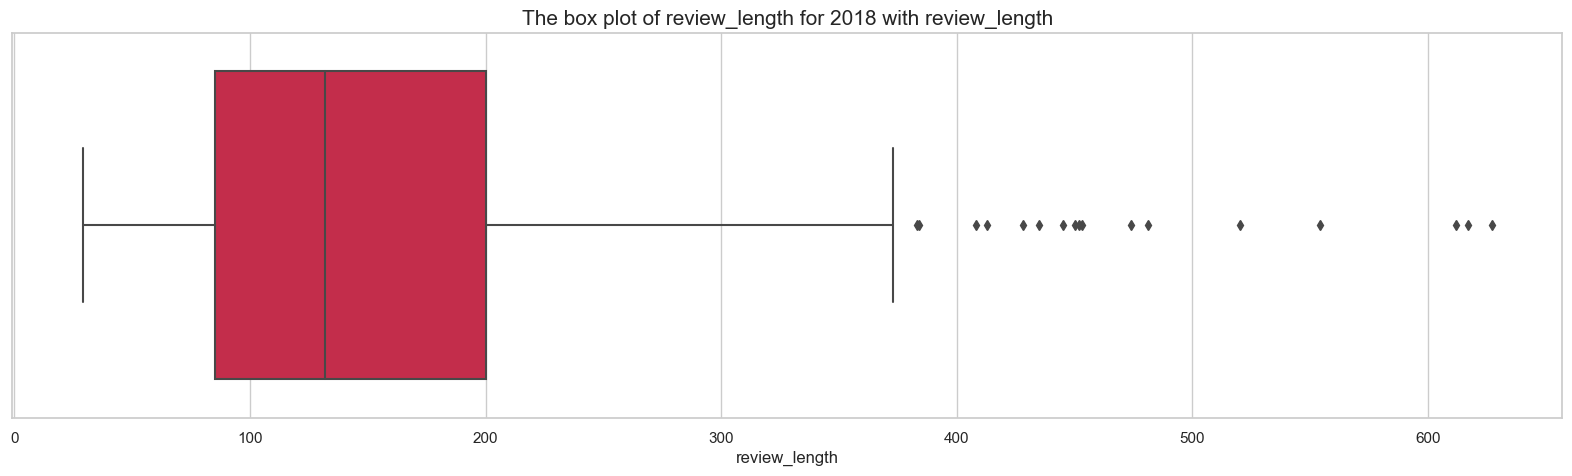

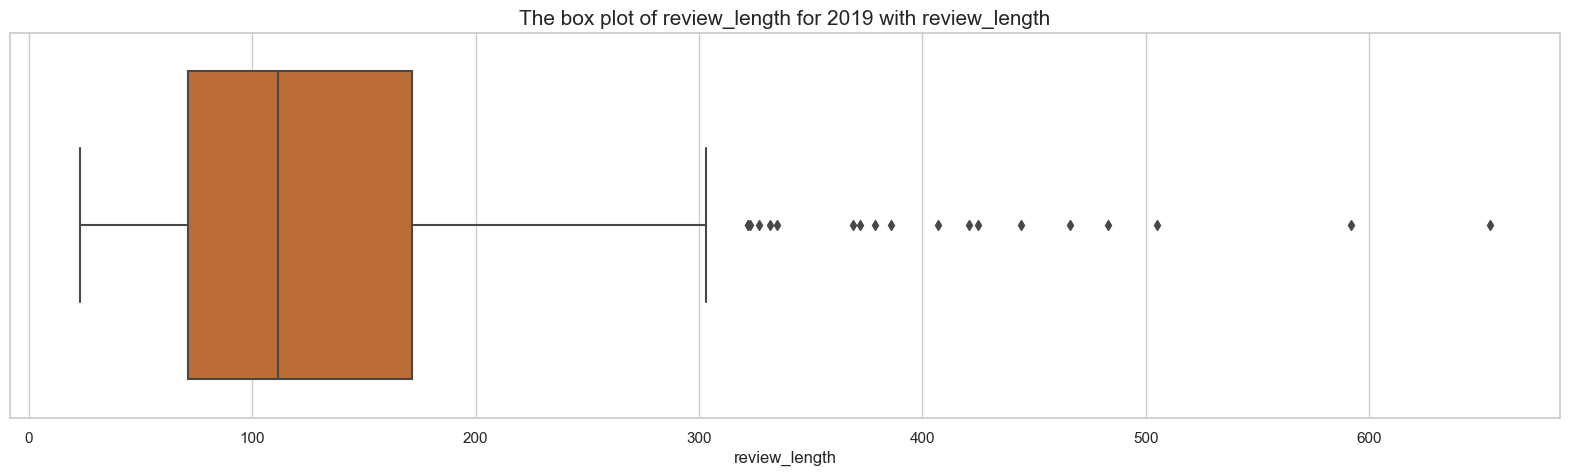

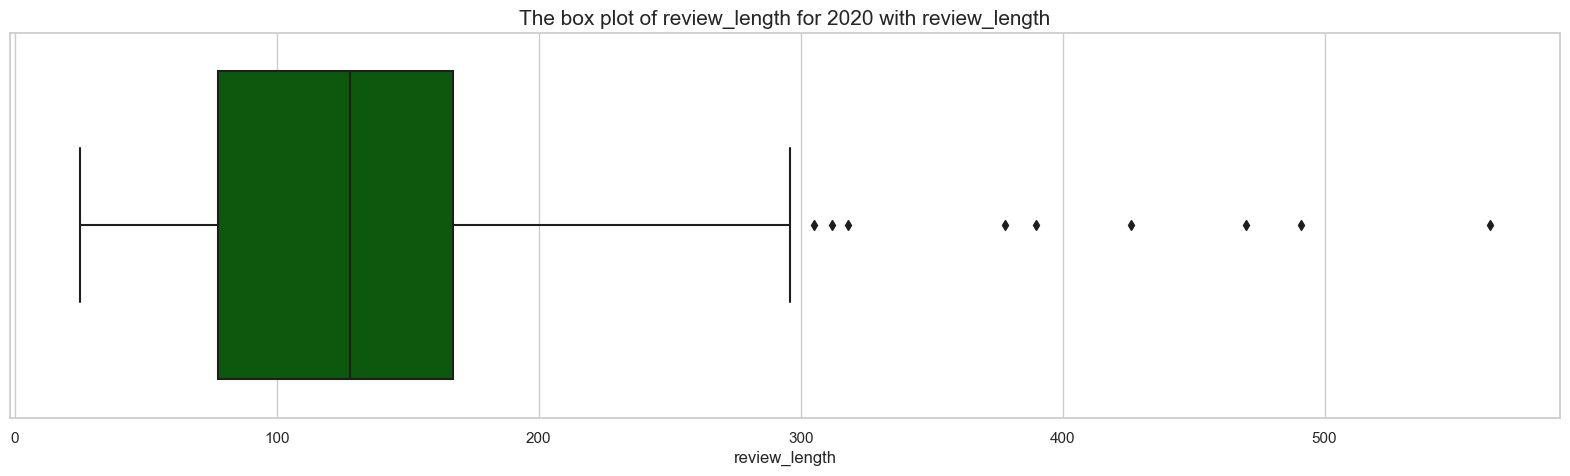

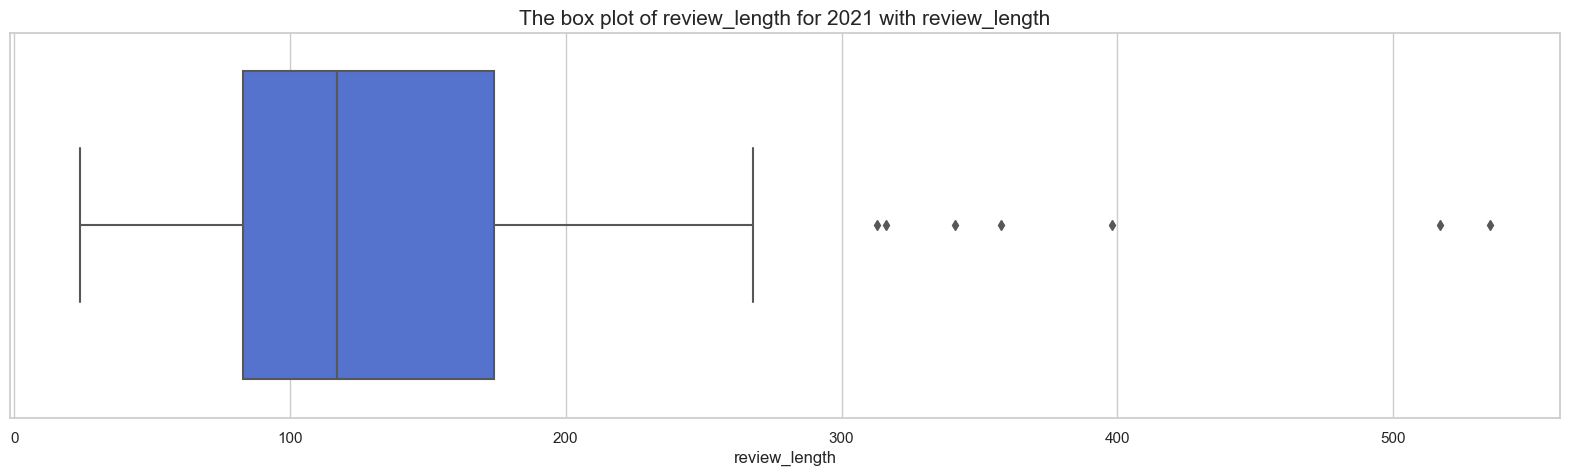

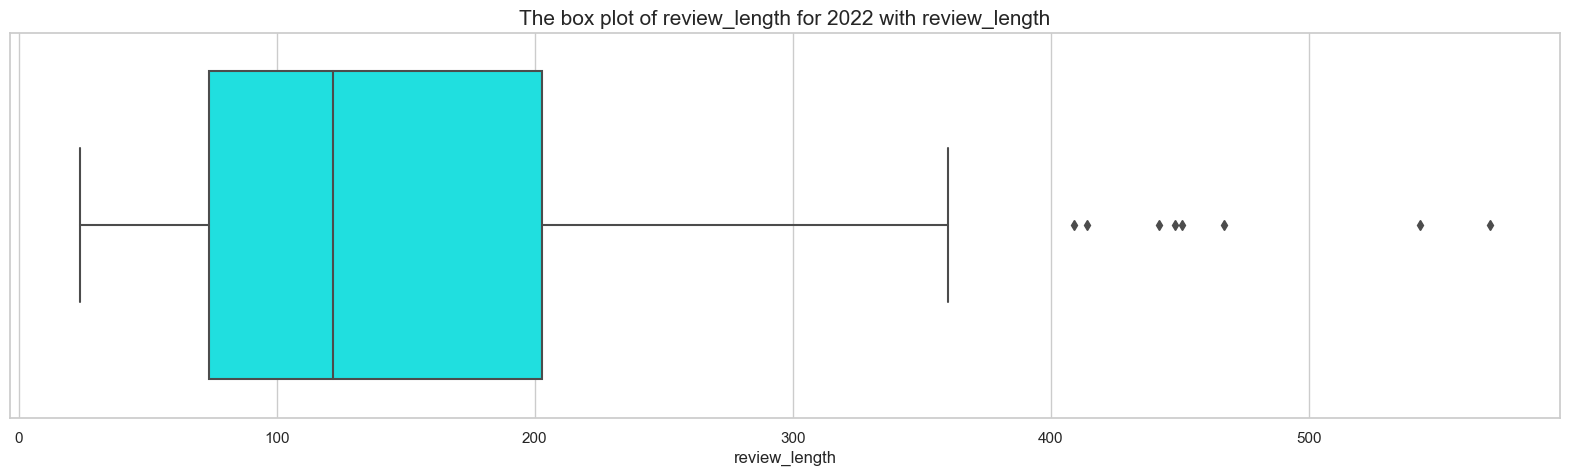

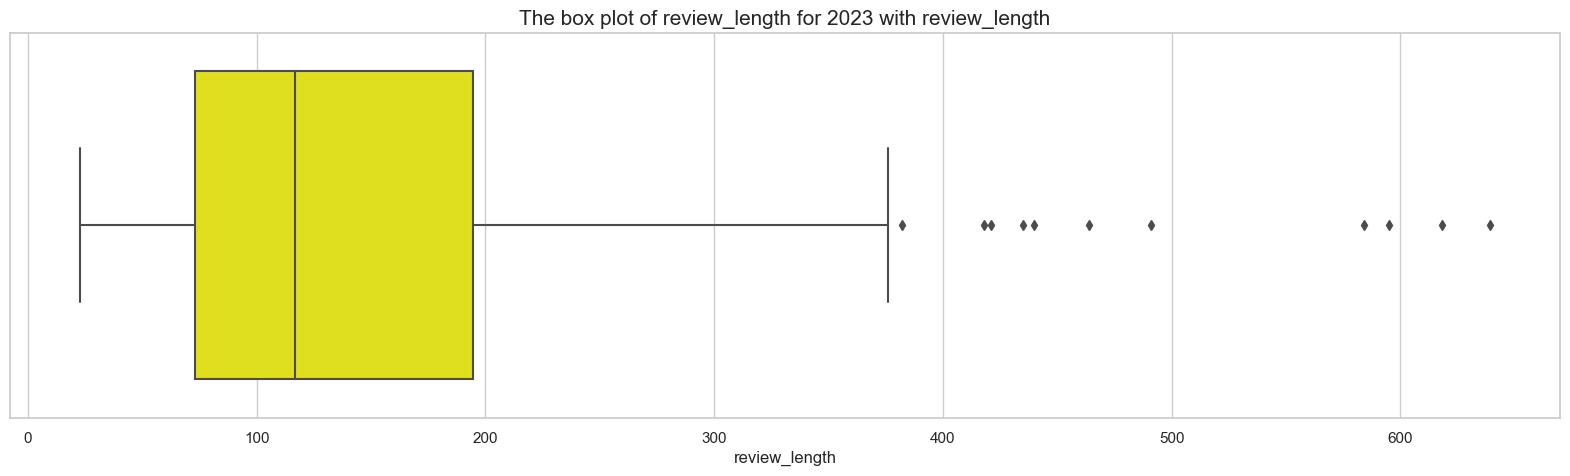

In [48]:
year_month('year')

In [49]:
# More dynamic
def year_month_hist(form:str):
    if form == 'month':
        date = list(text_anal.month.sort_values().unique()) 
    else:
        date = list(text_anal.year.sort_values().unique())       

    try:
        # date = list(text_anal.month.sort_values().unique())
        for index,val in enumerate(date):
            value = (text_anal[form] == val) # The boolean
            the_date_form = text_anal.loc[value] # New dataframe 

            colors_list = ['red','darkgreen','indigo','deepskyblue','darkmagenta','midnightblue',
                            'crimson','chocolate','darkgreen','royalblue','cyan','yellow']
            
            # Making the hist plot
            fig,ax = plt.subplots(1, figsize=(20,5),constrained_layout=True)
            sns.histplot(data=the_date_form,x='review_length',kde=True, color=colors_list[index])
            fig.suptitle(f"The Histogram plot for: {val} ",fontsize=15)
            ax.set_title(f"The review_length skewness: \
                {np.around(the_date_form['review_length'].skew(axis=0),3)}",fontdict={'size':10})
                
            plt.subplots_adjust(wspace=0.2)

    except ValueError:
            print(f"The wrong Key was passed\nPlease look are the information below\n")
            the_date_form.info(memory_usage='deep')

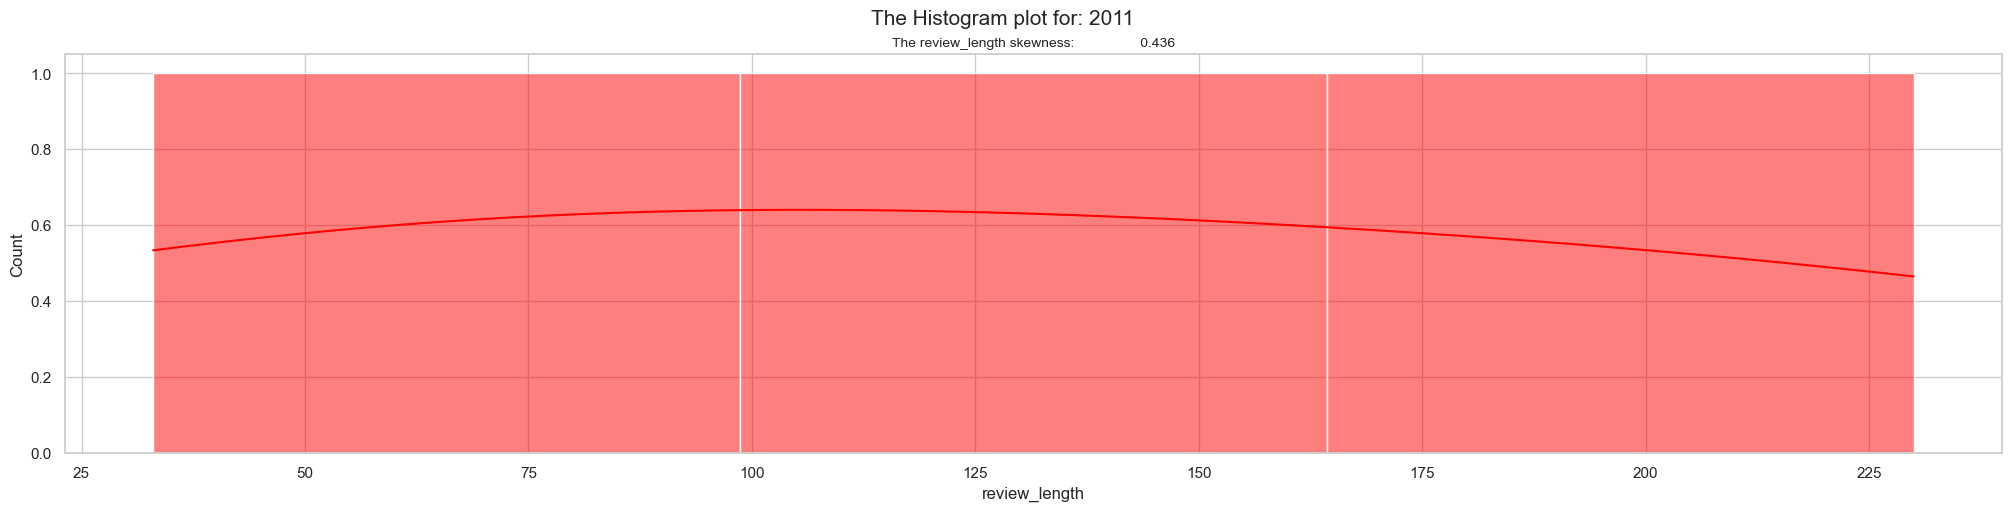

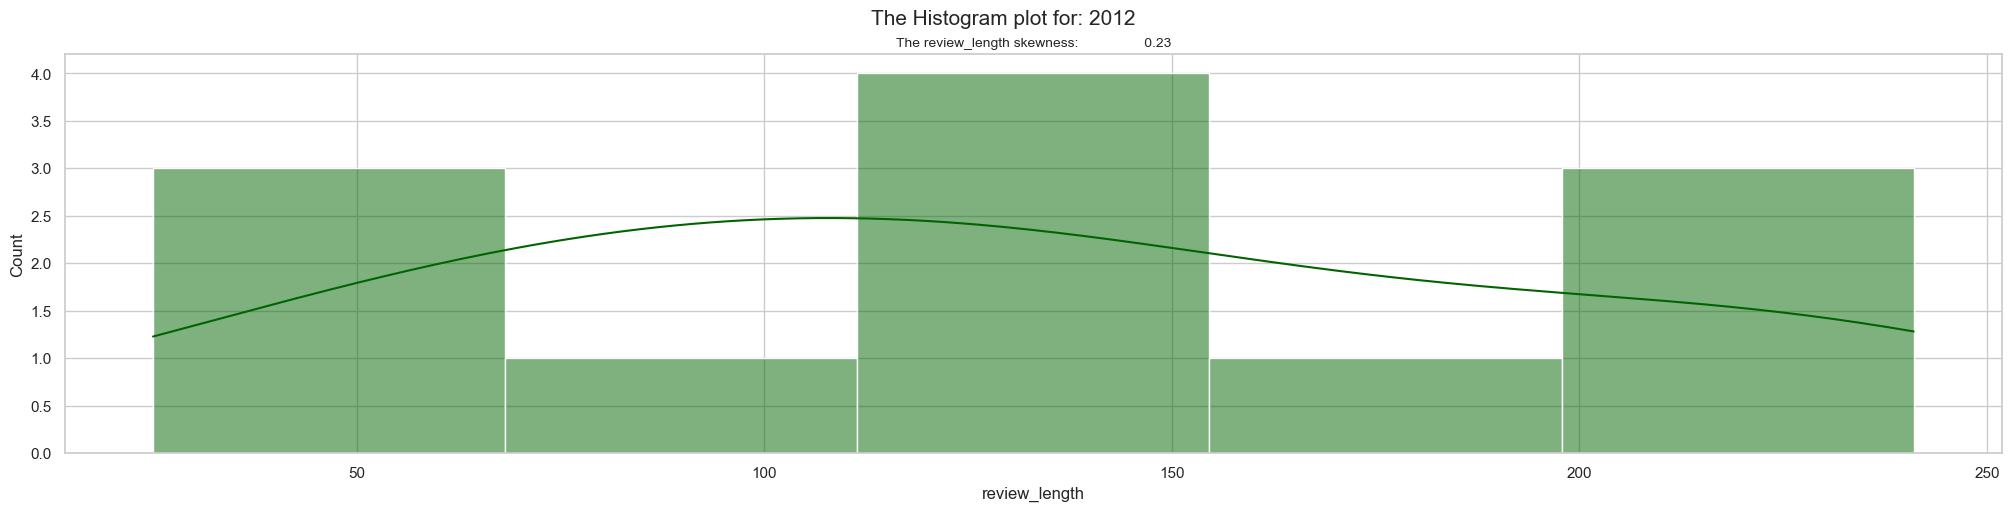

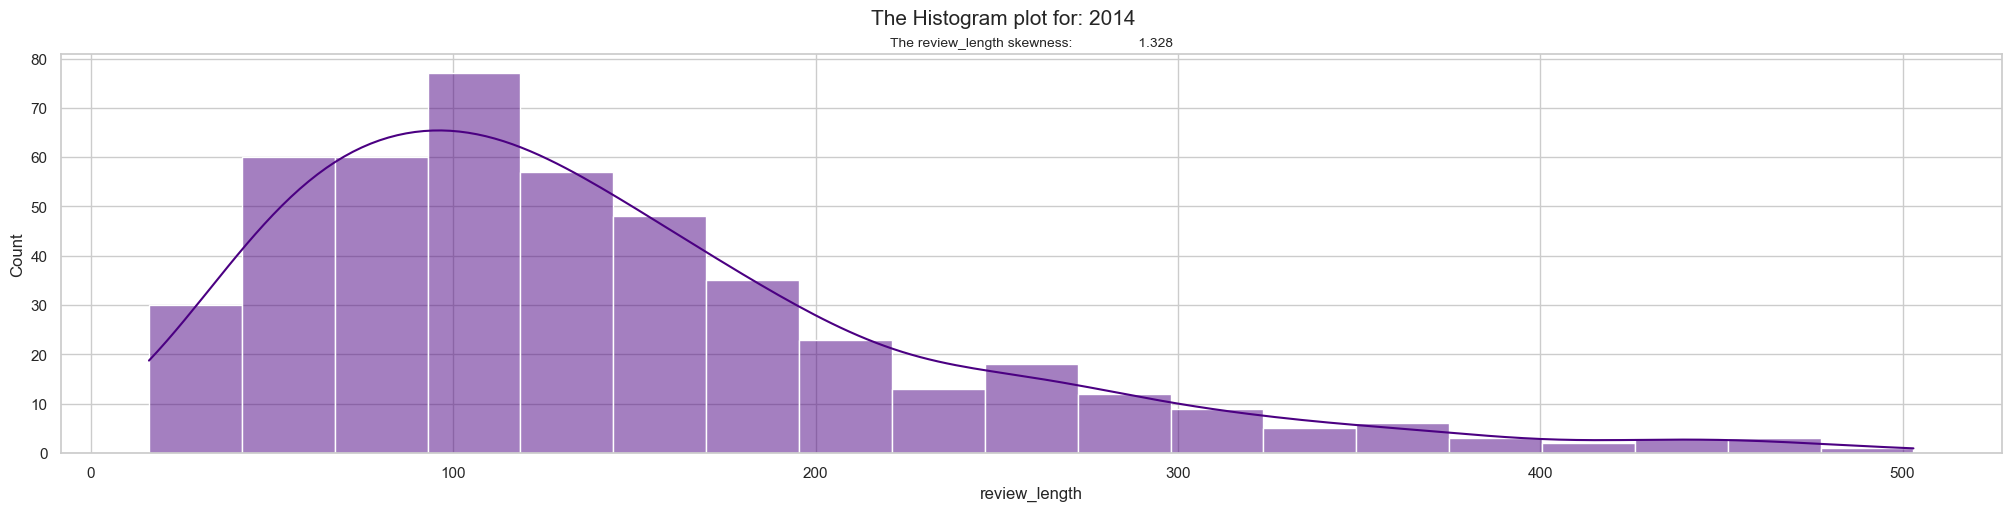

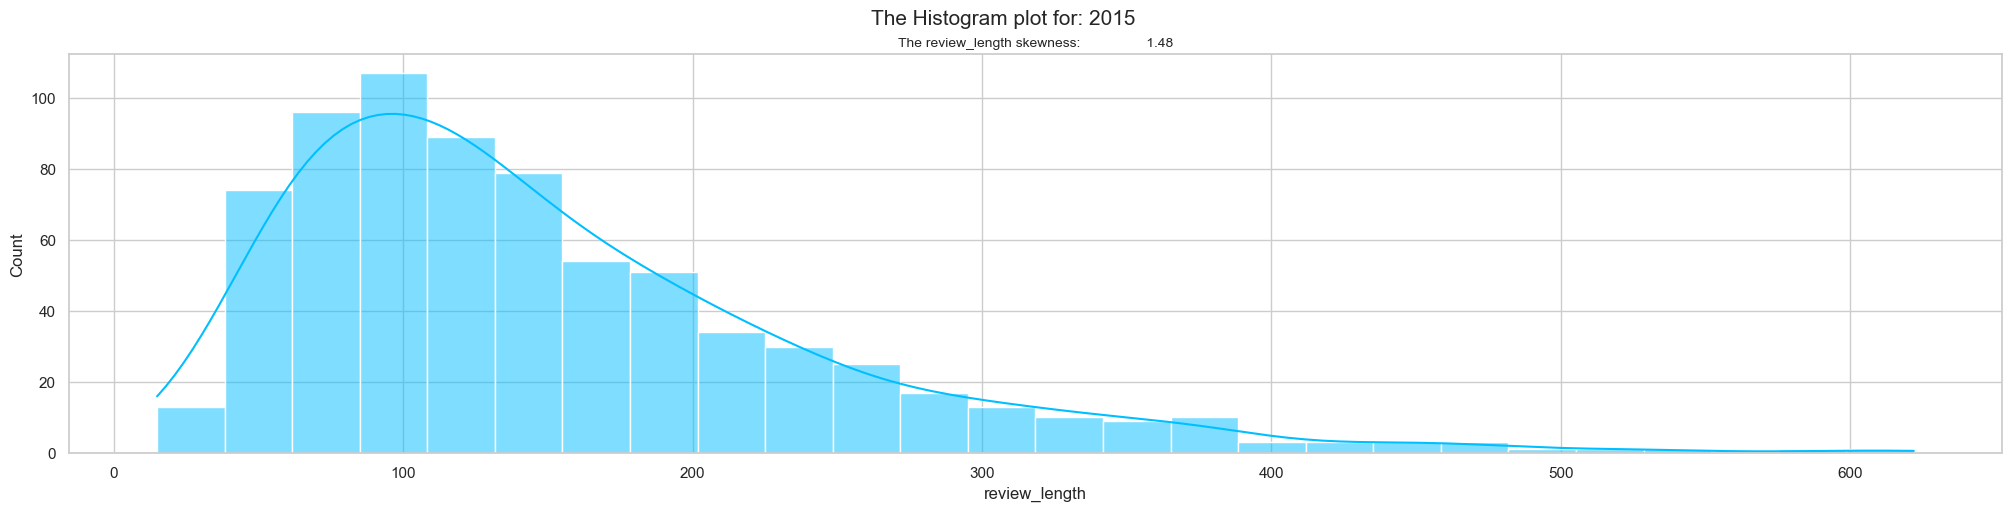

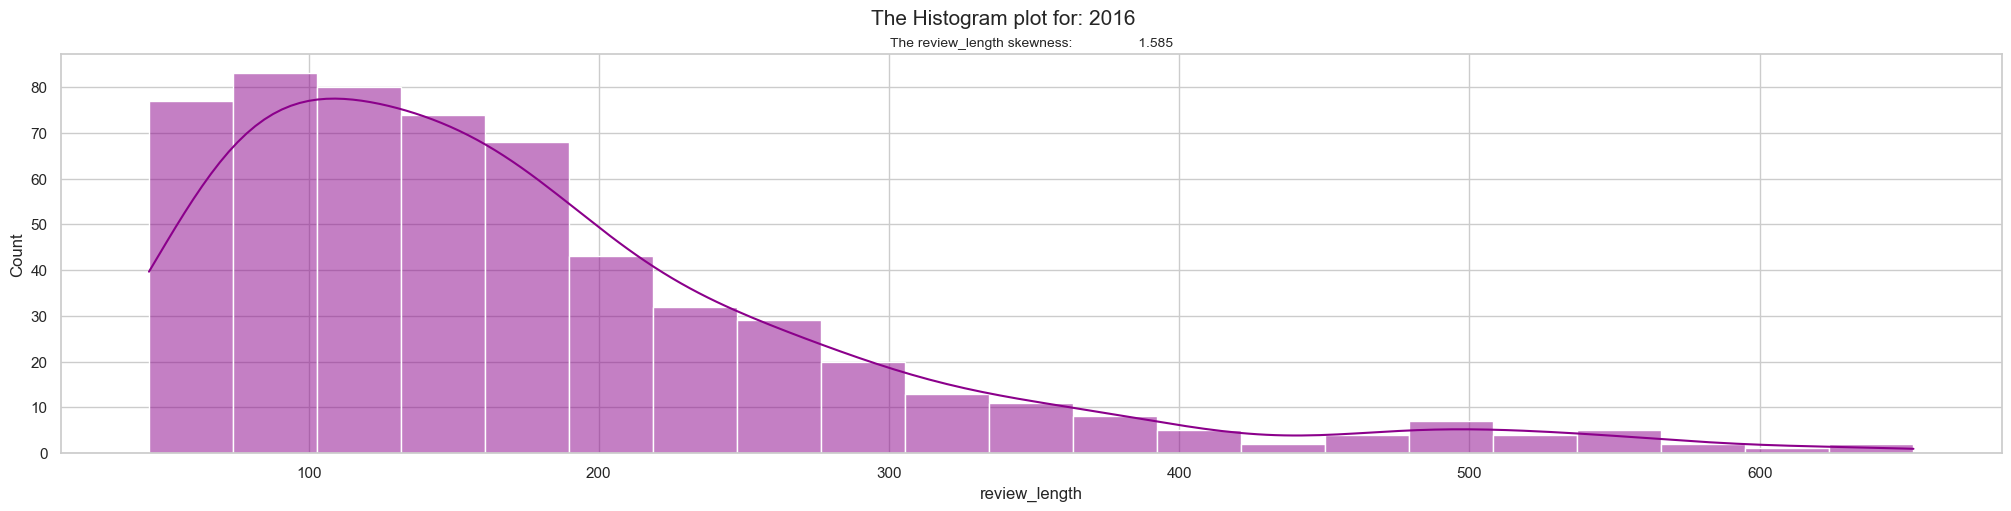

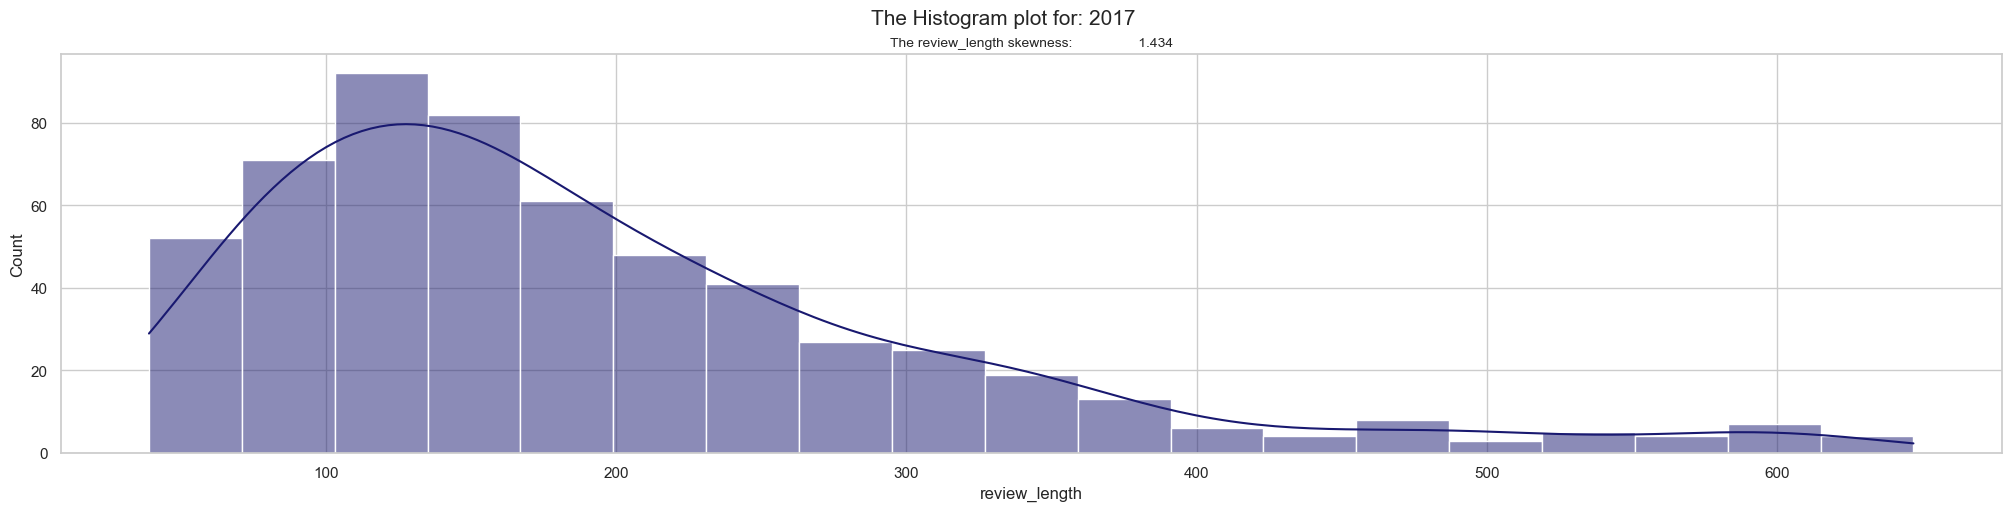

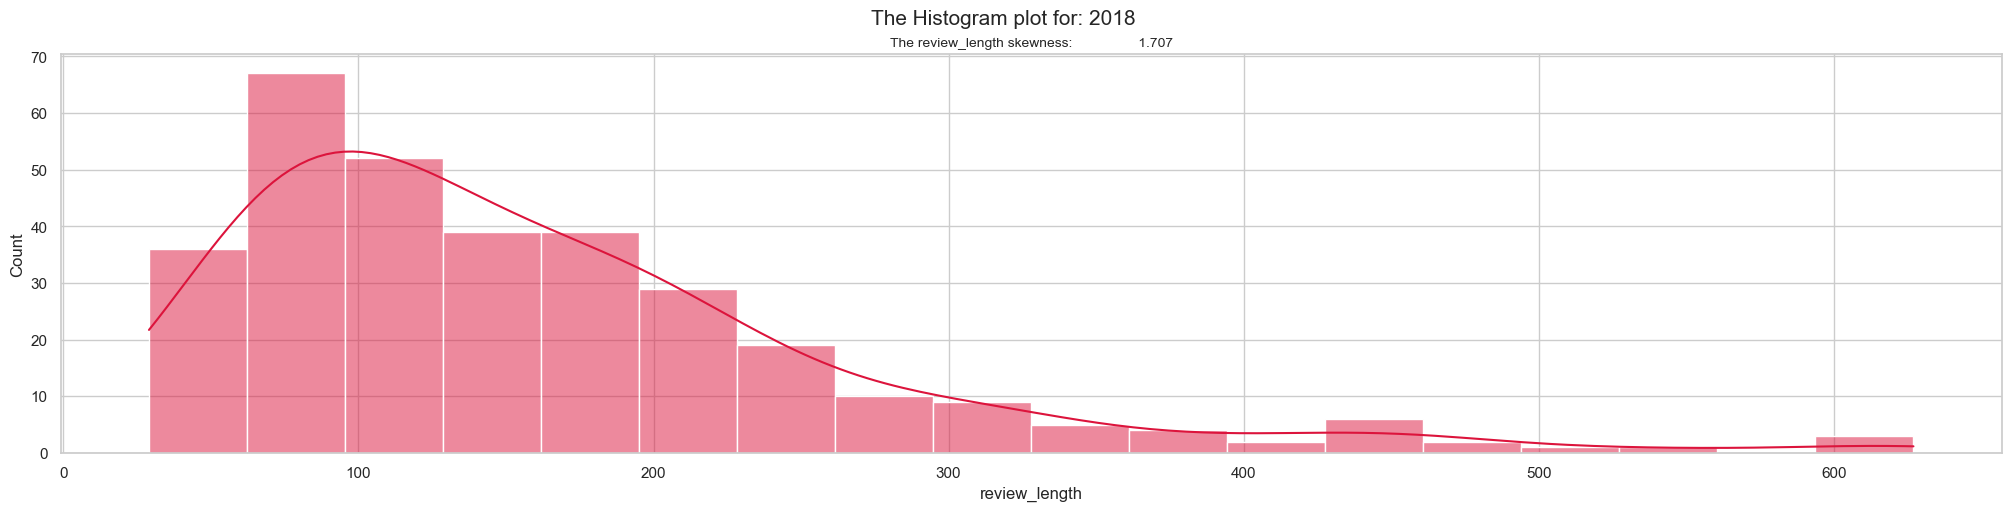

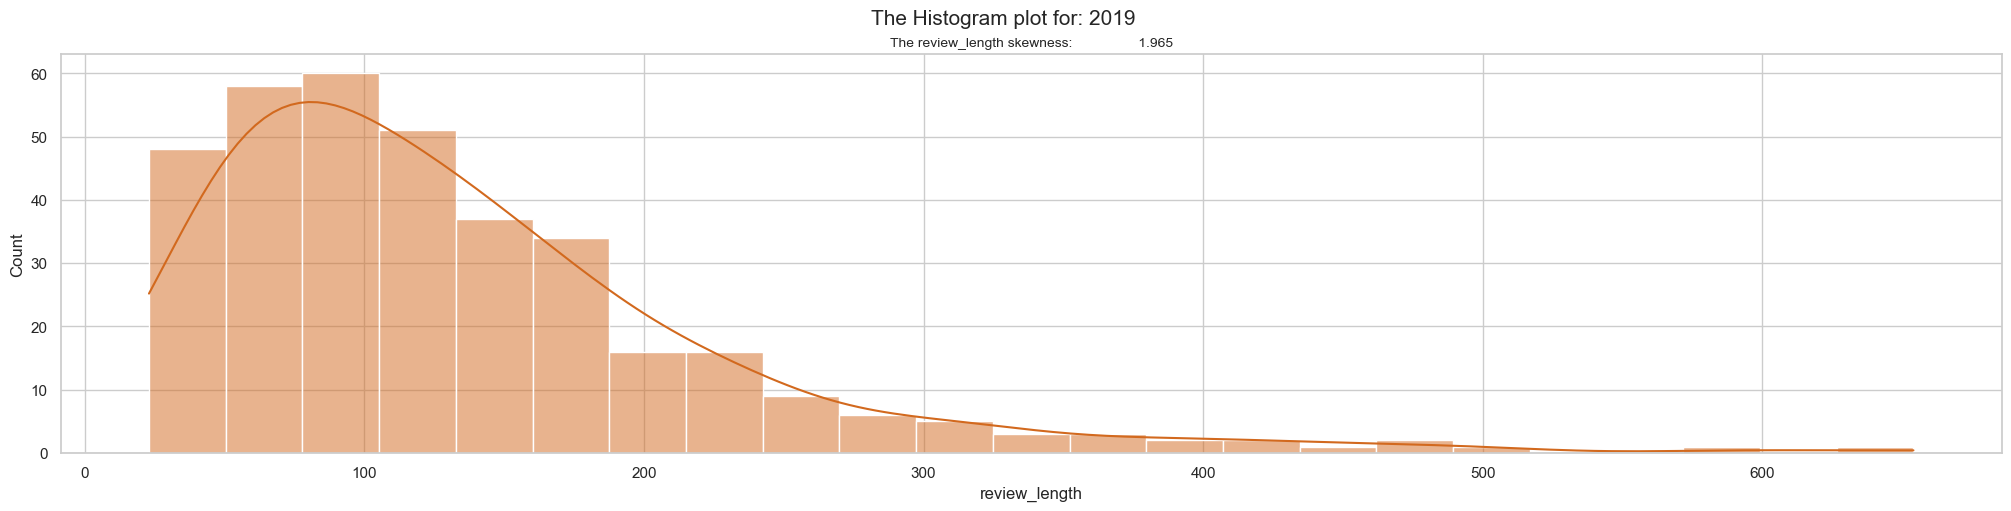

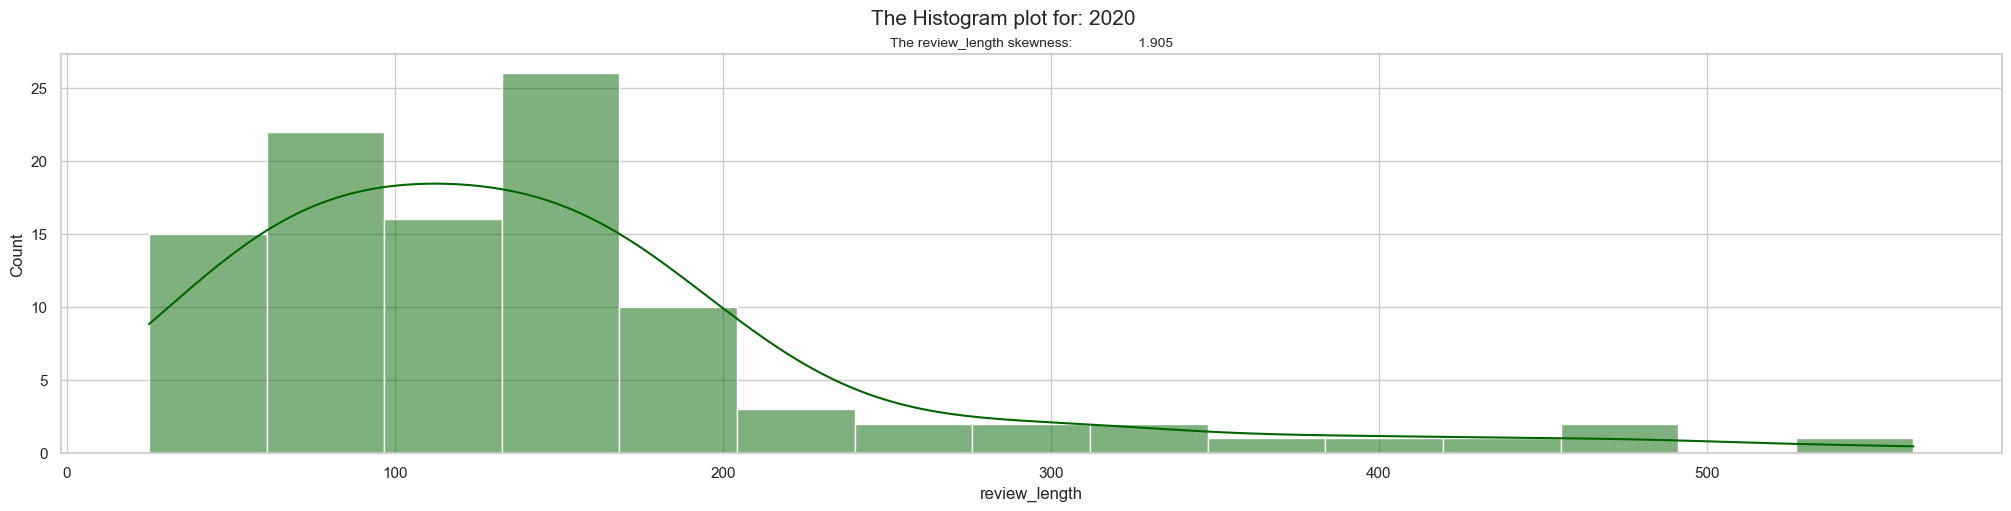

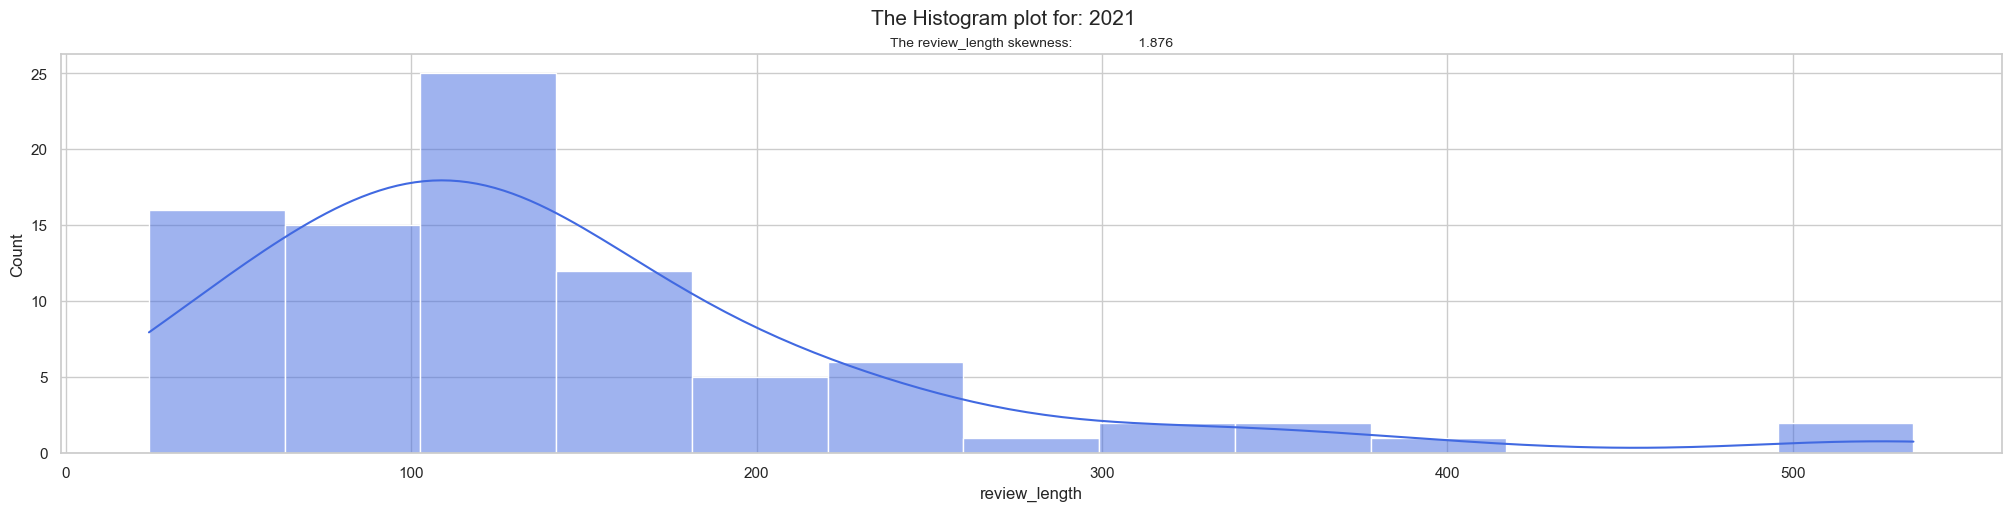

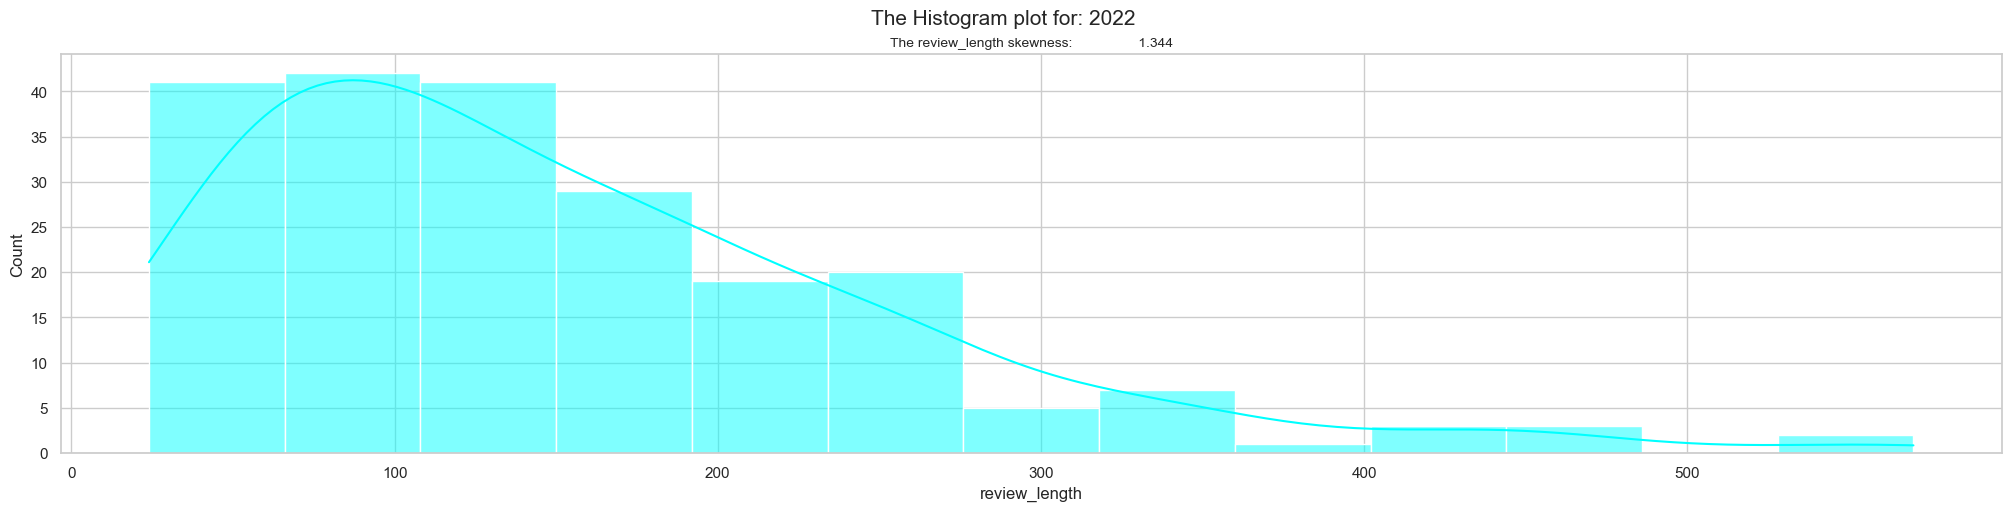

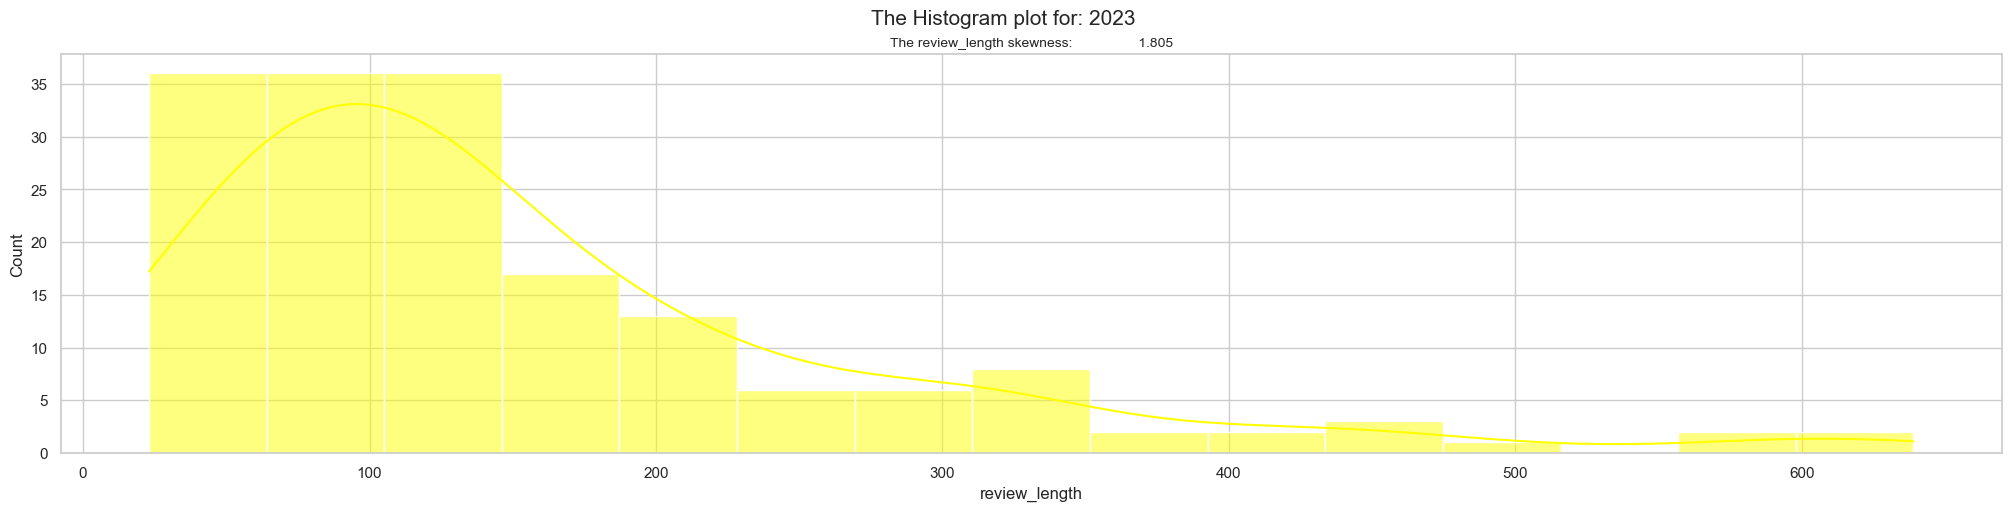

In [50]:
year_month_hist('year')

In [51]:
import os
# Define the path to the "month" folder within the "img" folder
folder_path1 = "img/month"
# Define the path to the "year" folder within the "img" folder
folder_path2 = "img/year"

# Create the "month" folder if it doesn't exist
os.makedirs(folder_path1, exist_ok=True)
# Create the "year" folder if it doesn't exist
os.makedirs(folder_path2, exist_ok=True)

In [52]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

mask = np.array(Image.open('img/cloud.png'))
def create_year_wordcloud(year_date='2011'):
    try:
        value = (text_anal.year == year_date) # boolean
        the_year = text_anal[value] # new dataframe
        stopwords = set(STOPWORDS)
        wc = WordCloud( max_font_size=40,
                                # background_color='white',
                                max_words=100,                        
                                stopwords=stopwords,
                                mask=mask,
                                margin=10,
                                random_state=42,
                                repeat=True)
                            
        wc.generate(str(the_year.review.values))
        
        wc.to_file(f"img/year/{year_date}_wordcloud.png")
        print(f"Word Cloud for {year_date} British Airways reviews has saved successfully")
        path = f'img/year/{year_date}_wordcloud.png'
        display(Image.open(path))
    except ValueError:
        print(f"The wrong value was passed\nPlease look are the information below for correct year range\n")
        print(text_anal.year.sort_values().unique())

Word Cloud for 2020 British Airways reviews has saved successfully


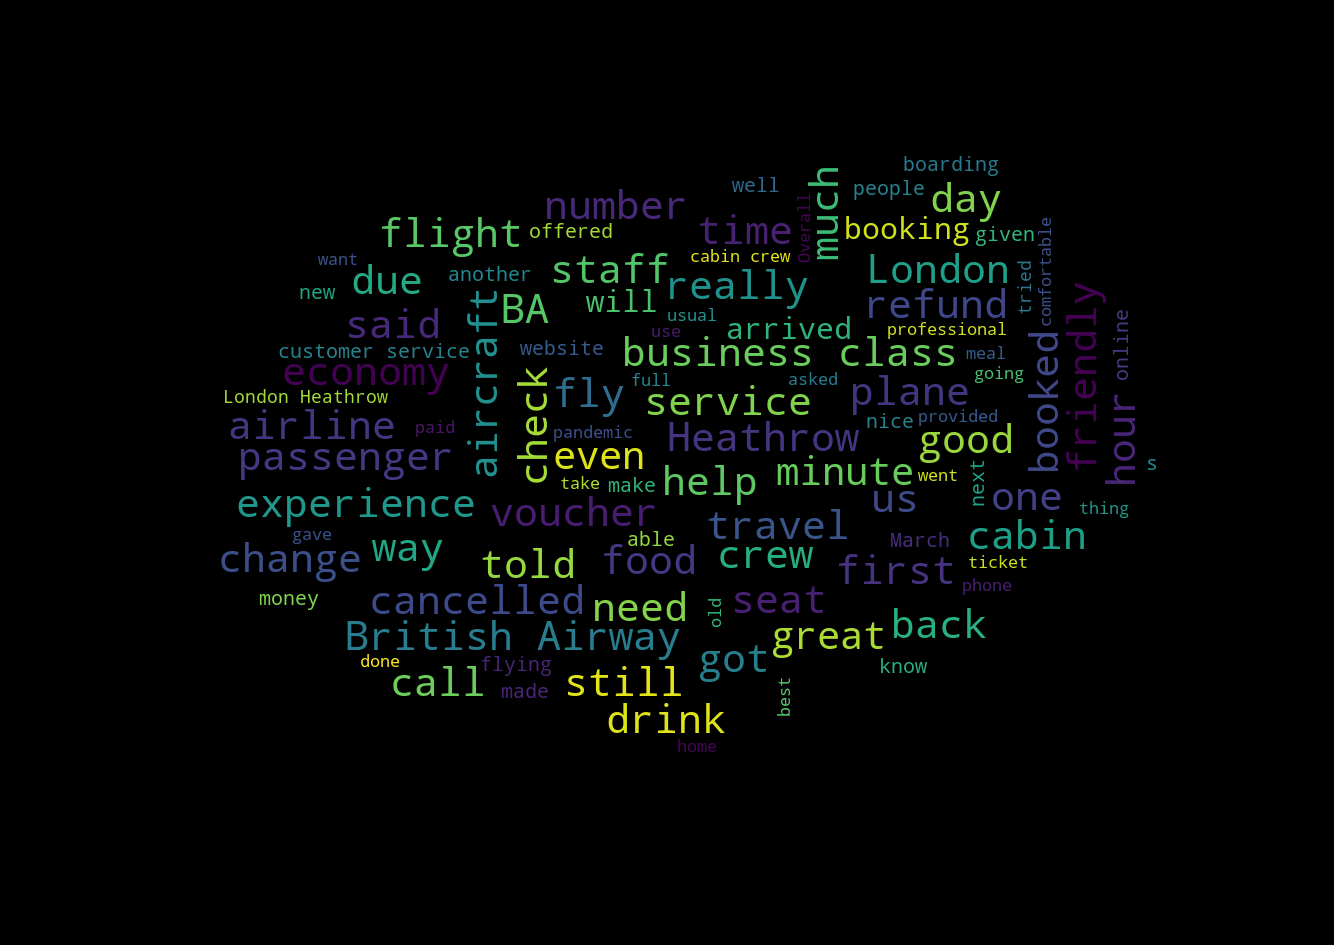

In [53]:
create_year_wordcloud("2020")

In [54]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

mask = np.array(Image.open('img/cloud.png'))
def create_month_wordcloud(month_date='01'):
    try:
        value = (text_anal.month == month_date) # boolean
        the_month = text_anal[value] # new dataframe
        stopwords = set(STOPWORDS)
        wc = WordCloud( max_font_size=40,
                                # background_color='white',
                                max_words=100,                        
                                stopwords=stopwords,
                                mask=mask,
                                margin=10,
                                random_state=42,
                                repeat=True)
                            
        wc.generate(str(the_month.review.values))
        month_translation = {"01":"January","02":"February","03":"March",
                            "04":"April","05":"May","06":"June",
                            "07":"July","08":"August","09":"September",
                            "10":"October","11":"November","12":"December"
        }
        wc.to_file(f"img/month/{month_translation[month_date]}_wordcloud.png")
        print(f"Word Cloud for {month_translation[month_date]} British Airways reviews has saved successfully")
        path = f'img/month/{month_translation[month_date]}_wordcloud.png'
        display(Image.open(path))
    except ValueError:
        print(f"The wrong value was passed\nPlease look are the information below for correct month range\n")
        print(text_anal.month.sort_values().unique())

Word Cloud for January British Airways reviews has saved successfully


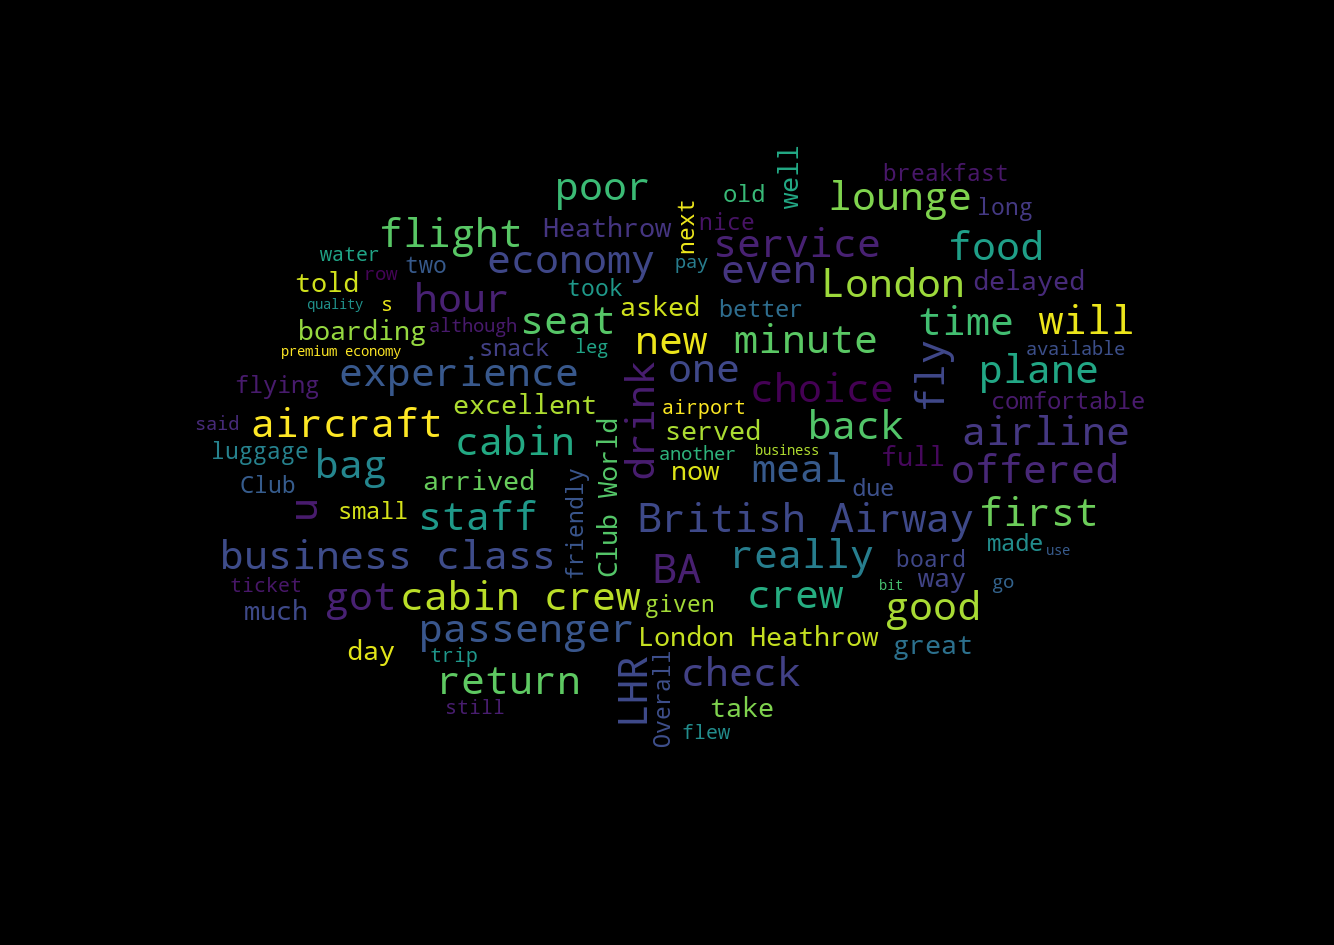

In [55]:
create_month_wordcloud()

Word Cloud for February British Airways reviews has saved successfully


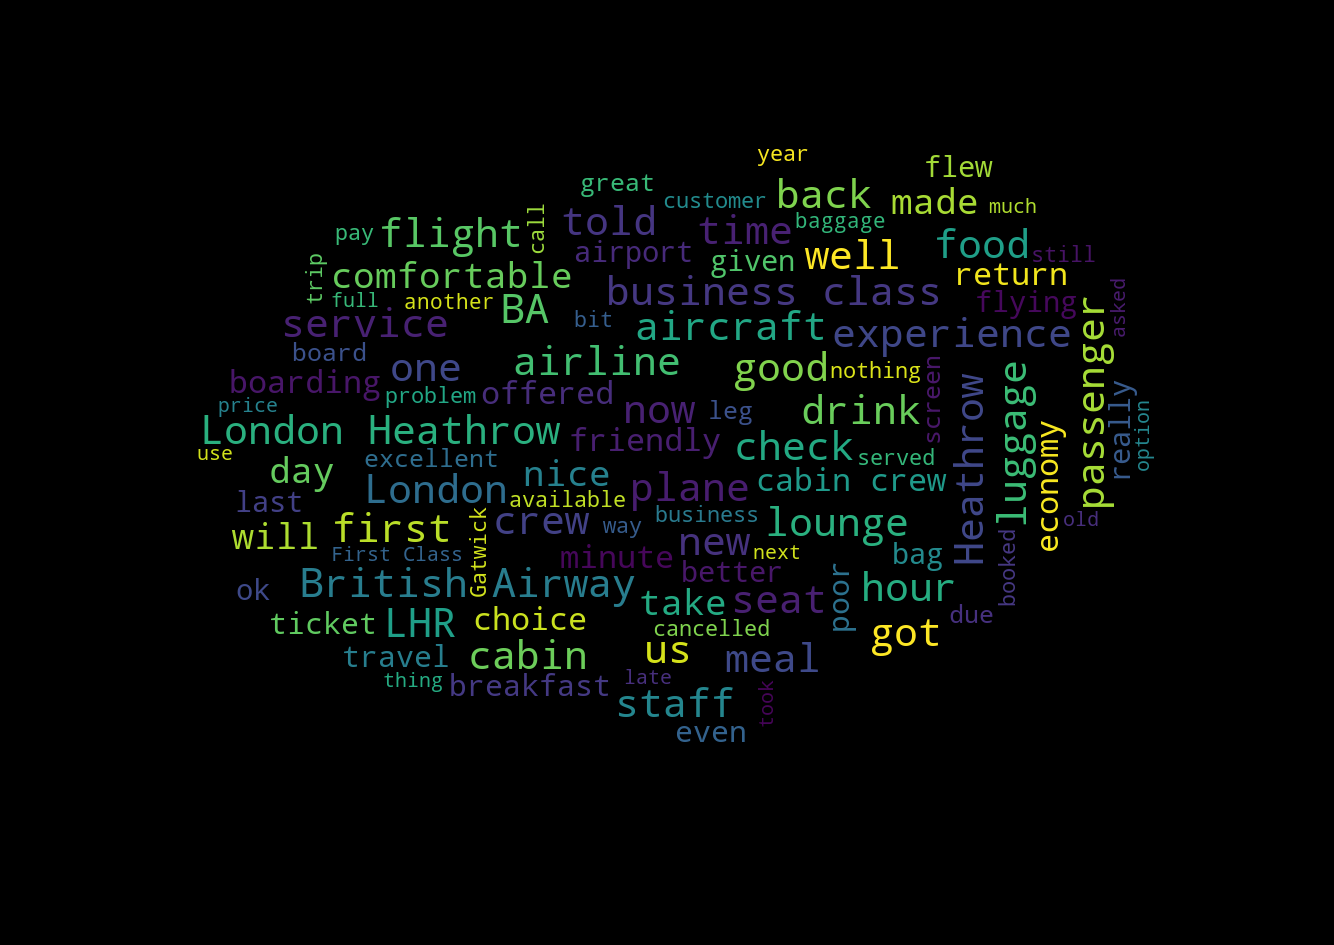

In [56]:
create_month_wordcloud("02")

Word Cloud for March British Airways reviews has saved successfully


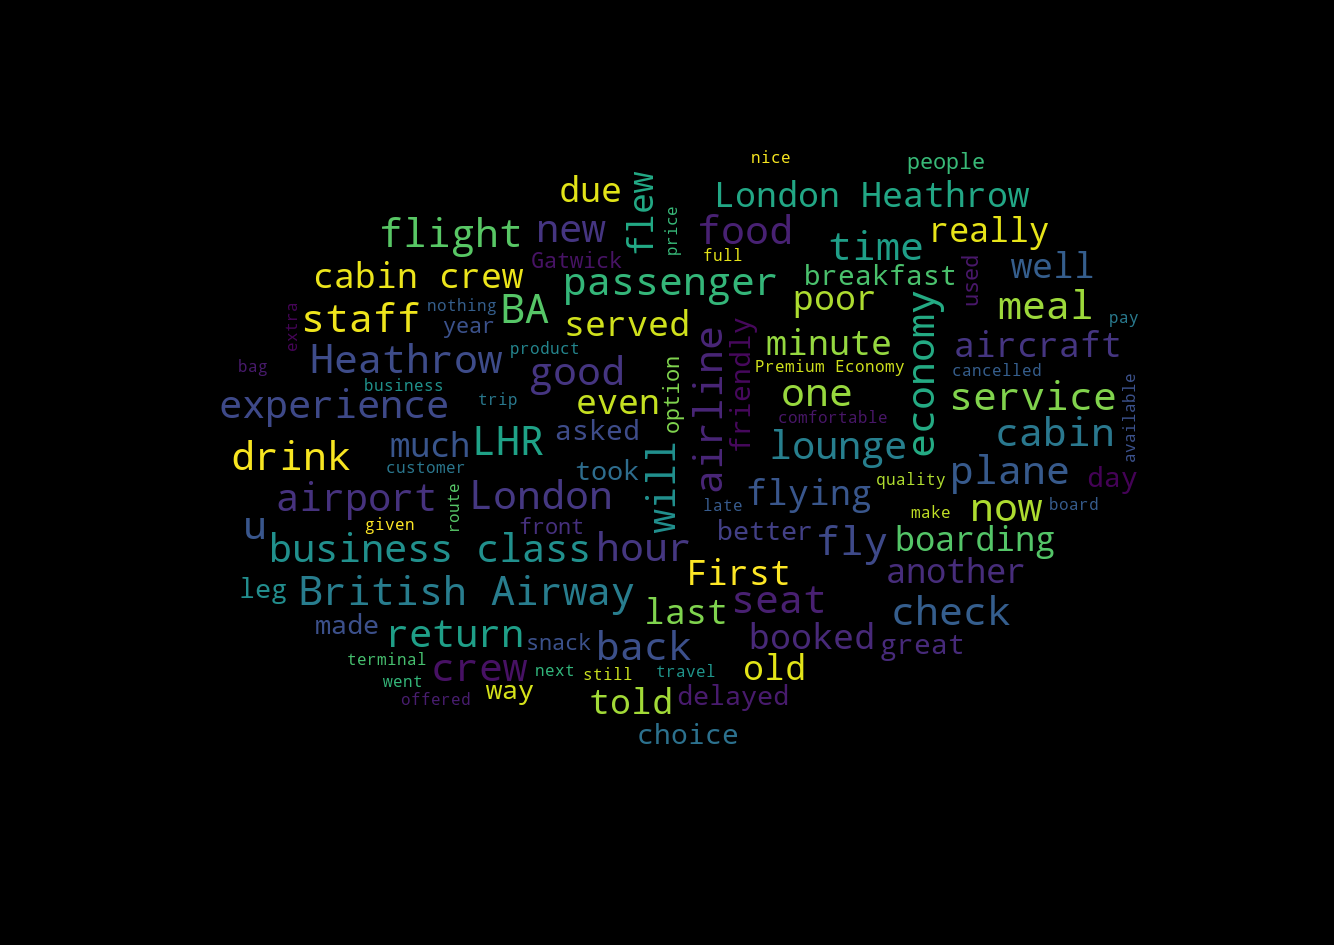

In [57]:
create_month_wordcloud("03")

In [58]:
folder_path1 = "img/year_month"

# Create the "month" folder if it doesn't exist
os.makedirs(folder_path1, exist_ok=True)

In [59]:
import sys

mask = np.array(Image.open('img/cloud.png'))
def create_year_month_wordcloud(month_date='01', year_date="2011"):
    month_translation = {
                    "01":"January","02":"February","03":"March",
                    "04":"April","05":"May","06":"June",
                    "07":"July","08":"August","09":"September",
                    "10":"October","11":"November","12":"December"
}
    try:
        # Loop through 
        while True:
            value = (text_anal.month == month_date) & (text_anal.year == year_date)  # boolean
            the_month_year = text_anal[value]  # new DataFrame
            if not the_month_year.empty:
                break  # Exit the loop if the DataFrame is not empty
            else:
                print(f"No combination of year {year_date} with month of {month_translation[month_date]}")
                user_month_date = input("Please input a new month or 'q' > ")
                user_year_date = input("Please input a new year  or 'q' > ")
                if user_month_date == "q" or user_year_date == "q":
                    print("Exiting program")
                    sys.exit("Goodbye from the program")  # Terminate the program

                # Update the month and year only if non-empty input is provided
                if user_month_date:
                    month_date = user_month_date
                if user_year_date:
                    year_date = user_year_date

        stopwords = set(STOPWORDS)
        wc = WordCloud( max_font_size=40,
                                # background_color='white',
                                max_words=100,                        
                                stopwords=stopwords,
                                mask=mask,
                                margin=10,
                                random_state=42,
                                repeat=True)
                            
        wc.generate(str(the_month_year.review.values))

        wc.to_file(f"img/year_month/{year_date}_{month_translation[month_date]}_wordcloud.png")
        print(f"Word Cloud for {year_date} {month_translation[month_date]} British Airways reviews has saved successfully")
        path = f"img/year_month/{year_date}_{month_translation[month_date]}_wordcloud.png"
        display(Image.open(path))
    except ValueError:
        print(f"The wrong value was passed\nPlease look are the information below for correct month range\n")
        print(text_anal.month.sort_values().unique(),"\n",text_anal.year.sort_values().unique())

In [60]:
create_year_month_wordcloud("02","2012")
# value = text_anal.year == "2023"  # boolean
# text_anal[value]  # new DataFrame

No combination of year 2012 with month of February
Exiting program


SystemExit: Goodbye from the program

In [61]:
text_anal.to_csv("../topic_modelling/data/cleaned.csv",index=False)